## 해결하고자 하는 문제
 - Daimler is challenging Kagglers to tackle the curse of dimensionality and reduce the time that cars spend on the test bench.
 - Winning algorithms will contribute to speedier testing, resulting in lower carbon dioxide emissions without reducing Daimler’s standards.
 - https://www.kaggle.com/c/mercedes-benz-greener-manufacturing

### 1. Import library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve
from sklearn.model_selection import KFold,RandomizedSearchCV
from sklearn.decomposition import PCA
seed =45

% matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# NaN value는 -1로 셋팅
train = pd.read_csv('./input/train_benz.csv',na_values=-1)
test = pd.read_csv('./input/test_benz.csv',na_values=-1)

print 'Number rows and columns:', train.shape
print 'Number rows and columns:', test.shape

Number rows and columns: (4209, 378)
Number rows and columns: (4209, 377)


### 2. EDA : 데이터 셋을 탐험해보자!
- 데이터셋 : https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data

In [3]:
train.head(5).T

,0,1,2,3,4
ID,0,6,7,9,13
y,130.81,88.53,76.26,80.62,78.02
X0,k,k,az,az,az
X1,v,t,w,t,v
X2,at,av,n,n,n
X3,a,e,c,f,f
X4,d,d,d,d,d
X5,u,y,x,x,h
X6,j,l,j,l,d
X8,o,o,x,e,n


- Target variable

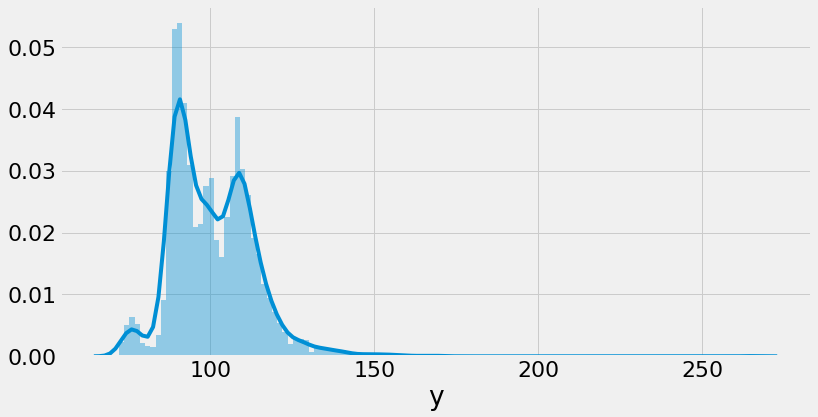

In [4]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22, 'figure.figsize': (12, 6)})

# Target 변수의 분포를 볼 수 있다.
sns.distplot(train['y'],bins=120)
plt.xlabel('y')

### 3. Correlation을 살펴보자.

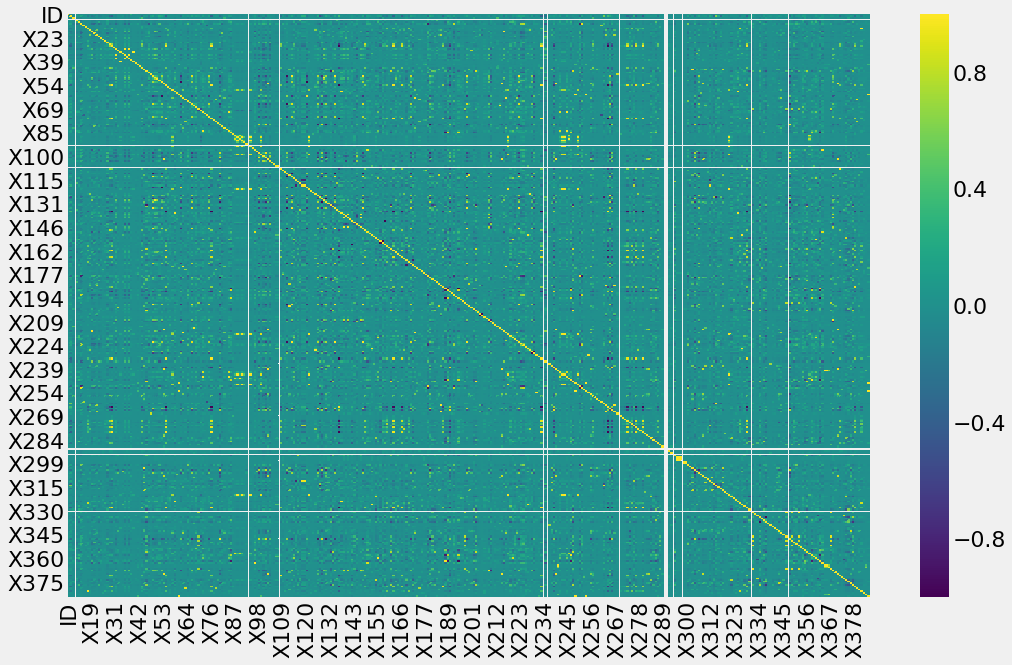

In [5]:
cor = train.corr()
plt.figure(figsize=(16, 10))

# cmap 참고 사이트 : http://bids.github.io/colormap/
sns.heatmap(cor, cmap='viridis')

### 4. 모델링 전, 데이터 셋의 missing value를 체크한다.

In [6]:
train.isnull().sum().sum()

0

In [7]:
test.isnull().sum().sum()

0

In [8]:
train_len = train.shape[0]
df = pd.concat([train, test], axis=0)

In [9]:
df.head()

,ID,X0,X1,X10,X100,X101,X102,X103,X104,X105,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,y
0,0,k,v,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,130.81
1,6,k,t,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,88.53
2,7,az,w,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,76.26
3,9,az,t,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,80.62
4,13,az,v,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,78.02


In [10]:
# 데이터가 binary 값으로 되어 있기 때문에, binary 값을 모두 가지고 있는 col 선택
bin_col = [c for c in df.columns if (df[c].nunique() == 2)]
len(bin_col)

368

In [11]:
# binary data를 (0, 1) 가지고 있는 col
other_col = [c for c in df.columns if c not in bin_col]
other_col

['ID', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8', 'y']

In [12]:
# binary data가 아닌 값을 가지는 col
df[other_col].nunique()

ID    8418
X0      53
X1      27
X2      50
X3       7
X4       4
X5      33
X6      12
X8      25
y     2545
dtype: int64

In [13]:
# binary data가 아닌 것은 category data로 타입을 지정한다.
col = df.columns

for i in col:
    if (2 < df[i].nunique() <= 53):
        df[i] = df[i].astype('category')

### 5. Univariate analysis
- single variable에 대하여 분석을 하는 것
- 변수간 인과관계나 상관관계를 다루지 않는다.
- 데이터를 분석하여 묘사하기 위해 주로 사용한다.

/Users/yoonjeonghun/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


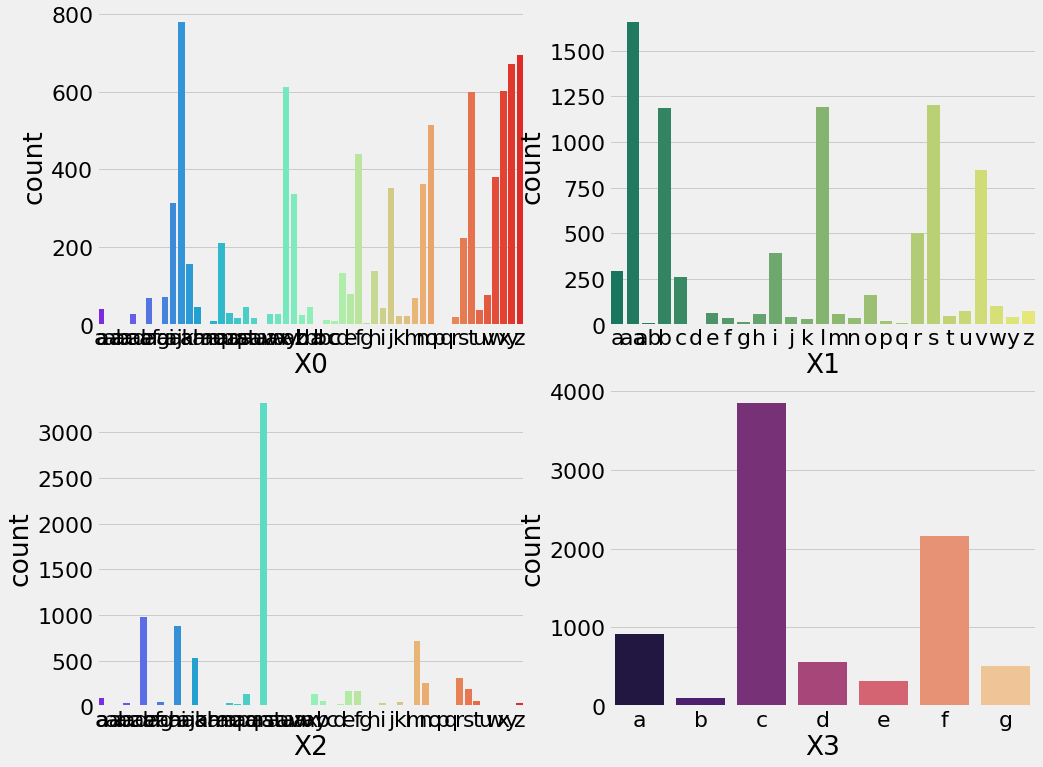

In [14]:
# category type
fig, ax = plt.subplots(2, 2, figsize=(15,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

ax1, ax2, ax3, ax4 = ax.flatten()

sns.countplot(df['X0'], palette='rainbow', ax=ax1)
sns.countplot(df['X1'], palette='summer', ax=ax2)
sns.countplot(df['X2'], palette='rainbow', ax=ax3)
sns.countplot(df['X3'], palette='magma', ax=ax4)

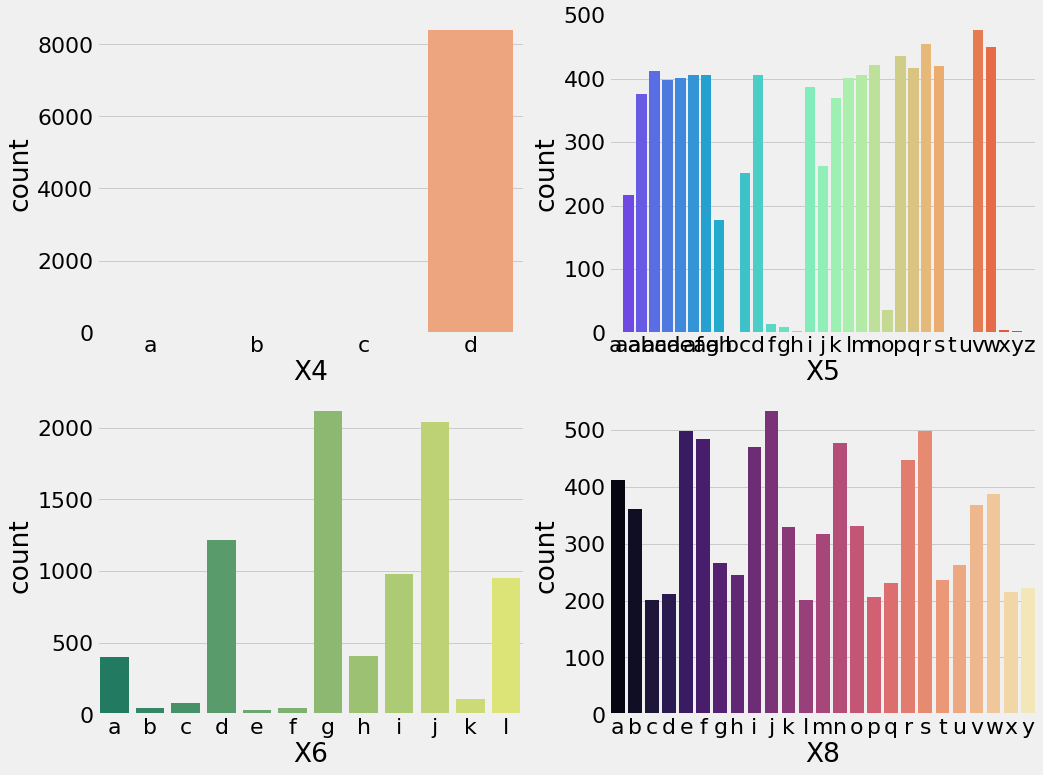

In [27]:
# category type
fig,ax = plt.subplots(2, 2, figsize=(15,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

ax1, ax2, ax3, ax4 = ax.flatten()

sns.countplot(df['X4'], palette='magma', ax=ax1)
sns.countplot(df['X5'], palette='rainbow', ax=ax2)
sns.countplot(df['X6'], palette='summer', ax=ax3)
sns.countplot(df['X8'], palette='magma', ax=ax4)

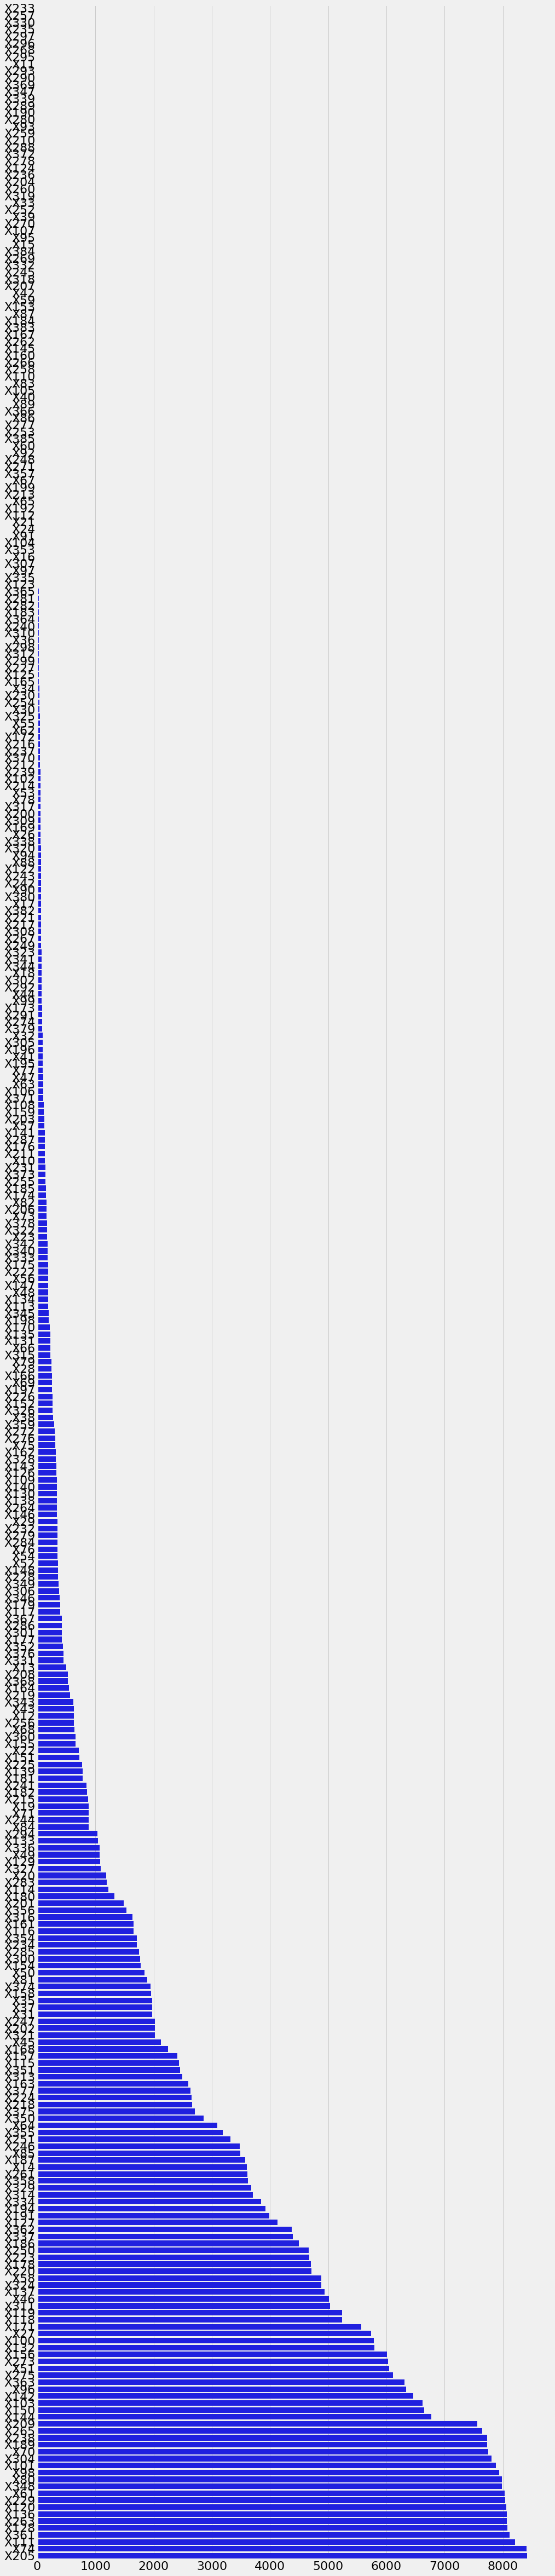

In [16]:
# binary type
plt.figure(figsize=(15, 80))
k = df[bin_col].sum().sort_values()
sns.barplot(k, k.index, orient='h', color='b')

### 6. Category data를 numeric data로 바꾸자! <U>Onehot encoding</U>

In [28]:
# category type feature column
col_ohe = ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']

# c2 : 컬럼 이름 리스ㅌ,
new_cate_col = {}

for c in col_ohe:
    new_cate_col[c] = 'ohe_'+c
    
# category data를 수치화하는 메소드
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
df1 = pd.get_dummies(df, prefix=new_cate_col, columns=col_ohe, drop_first=True)
print 'Size', df1.shape

Size (8418, 573)


In [29]:
new_cate_col

{'X0': 'ohe_X0',
 'X1': 'ohe_X1',
 'X2': 'ohe_X2',
 'X3': 'ohe_X3',
 'X4': 'ohe_X4',
 'X5': 'ohe_X5',
 'X6': 'ohe_X6',
 'X8': 'ohe_X8'}

In [30]:
df1.head()

,ID,X10,X100,X101,X102,X103,X104,X105,X106,X107,...,ohe_X8_p,ohe_X8_q,ohe_X8_r,ohe_X8_s,ohe_X8_t,ohe_X8_u,ohe_X8_v,ohe_X8_w,ohe_X8_x,ohe_X8_y
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 7. 차원의 저주를 줄이기 위하여 feature를 줄인다. -> <U>PCA</U> 사용

In [31]:
# n_component를 None으로 하면 모든 component를 다 선택한다는 의미이다.
pca = PCA(n_components=None, random_state=seed)
pca.fit(df1.drop(['y','ID'],axis=1))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=45,
  svd_solver='auto', tol=0.0, whiten=False)

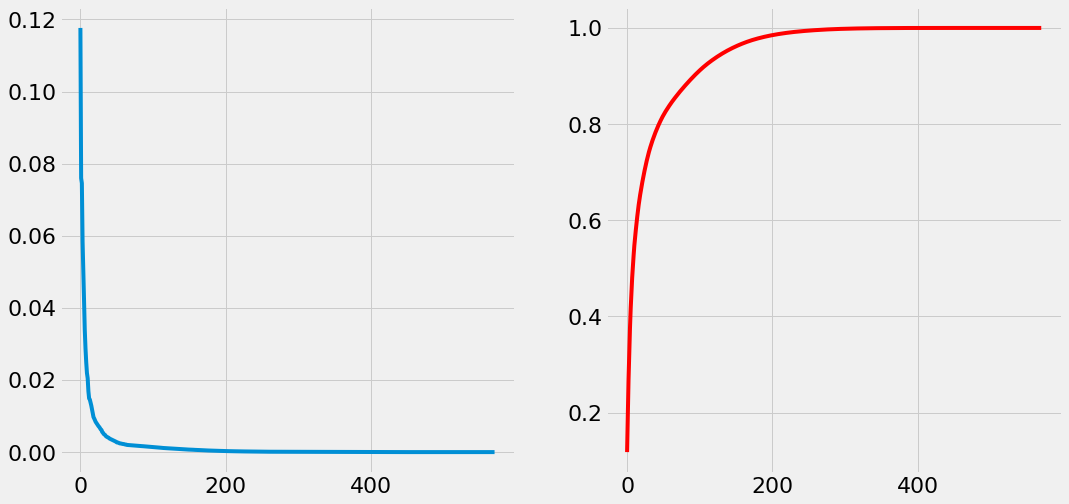

In [32]:
# 분산에서 각각의 component들이 차지하는 비율
pca_var = pca.explained_variance_ratio_
fig,ax = plt.subplots(1, 2, figsize=(16, 8))
ax1,ax2, = ax.flatten()
ax1.plot(pca_var)

pca_var_cum = np.cumsum(pca_var)
ax2.plot(pca_var_cum,color='r')

In [33]:
# 위 그림에서 알 수 있듯이 300개의 variable로 전체 모델이 설명가능하다.
pca = PCA(n_components=300, random_state=seed)

# dimesional reduction까지 완료
df_pca = pca.fit_transform(df1.drop(['y','ID'], axis=1))

### 8. 학습에 사용될 데이터를 split 한다.

In [34]:
# training set
X = df_pca[:train_len,]
y = df1[:train_len]['y']

# test set
x_test = df_pca[train_len:,]

X.shape, y.shape, x_test.shape

((4209, 300), (4209,), (4209, 300))

### 9. 모델링

In [35]:
# k-fold를 사용한다.
kf = KFold(n_splits=3, random_state=seed, shuffle=True)

pred_test_full=0
cv_score=[]
i=1

for train_index, test_index in kf.split(X, y):    
    print '\n{} of kfold {}'.format(i, kf.n_splits)
    
    # k-fold에서 train과 test를 나눈것 (여기서 테스트는 validation을 의미)
    xtr, xvl = X[train_index], X[test_index]
    ytr, yvl = y[train_index], y[test_index]
    
    lr = LinearRegression()
    lr.fit(xtr, ytr)
    
    pred_test = lr.predict(xvl)
    score = lr.score(xvl, yvl)
    print'R square score', score
    cv_score.append(score)
    
    # 모델을 이용하여 예측한 값
    pred_test_full += lr.predict(x_test)
    i+=1


1 of kfold 3
R square score 0.553837560575

2 of kfold 3
R square score 0.547593630611

3 of kfold 3
R square score 0.453596730397


In [36]:
print 'Cv : ', cv_score
print 'Mean cv Score : ', np.mean(cv_score)
print 'std : ', np.std(cv_score)

Cv :  [0.55383756057471478, 0.54759363061103405, 0.45359673039683351]
Mean cv Score :  0.518342640528
std :  0.0458531810917


### 10. 테스트 결과

In [37]:
y_pred = pred_test_full / 3
submit = pd.DataFrame({'ID' : test['ID'], 'y' : y_pred})

submit.head()

,ID,y
0,1,80.255407
1,2,94.763322
2,3,83.615836
3,4,78.489048
4,5,112.026032
